# US Election Map
A map of us presedential election results through time

In [122]:
#Imports 
import numpy as np
import pandas as pd

import json
import datetime


from shapely.geometry import Polygon, mapping
import geopandas as gpd

import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import folium
from folium.plugins import TimeSliderChoropleth

## US Shape File

In [123]:
#Get US states shapefile
us_shape = gpd.read_file('../data/States 21basic/geo_export_65f74268-7da4-45cb-b582-640700c3c767.shp')
us_shape = us_shape[['state_name','geometry']]
print(len(us_shape))
us_shape.head()

51


,state_name,geometry
0,Hawaii,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,(POLYGON ((-122.4020153103836 48.2252163723779...
2,Montana,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,POLYGON ((-98.73043728833767 45.93827137024809...


In [124]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json())
m.add_child(choropleth)

In [125]:
#Get election data
election = pd.read_csv("../data/1976-2016-president.csv" )
election.replace('democratic-farmer-labor','democrat',inplace=True)
election

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN
5,1976,Alabama,AL,1,63,41,US President,"Macbride, Roger",libertarian,False,1481,1182850,20171015,NaN
6,1976,Alabama,AL,1,63,41,US President,NaN,NaN,True,308,1182850,20171015,NaN
7,1976,Alaska,AK,2,94,81,US President,"Ford, Gerald",republican,False,71555,123574,20171015,NaN
8,1976,Alaska,AK,2,94,81,US President,"Carter, Jimmy",democrat,False,44058,123574,20171015,NaN
9,1976,Alaska,AK,2,94,81,US President,"Macbride, Roger",libertarian,False,6785,123574,20171015,NaN


In [126]:
# Transform election data 
states = set(election['state'])

results = {}
for year in range(1976,2020,4):
    result = {}
    for state in states:
        state_year = election[(election.year == year) 
                              & (election.state == state)]
        dem = max(state_year[state_year.party == 'democrat']['candidatevotes'])
        rep = max(state_year[state_year.party == 'republican']['candidatevotes'])
        
        result[state] = {'dem':dem, 'rep':rep}
        
    results[year] = result
    
results

{1976: {'New Jersey': {'dem': 1444653, 'rep': 1509688},
  'Georgia': {'dem': 979409, 'rep': 483743},
  'Rhode Island': {'dem': 227636, 'rep': 181249},
  'Nebraska': {'dem': 233293, 'rep': 359219},
  'South Carolina': {'dem': 450807, 'rep': 346149},
  'California': {'dem': 3742284, 'rep': 3882244},
  'Pennsylvania': {'dem': 2328677, 'rep': 2205604},
  'New Hampshire': {'dem': 147645, 'rep': 185935},
  'Wisconsin': {'dem': 1040232, 'rep': 1004987},
  'Montana': {'dem': 149259, 'rep': 173703},
  'Utah': {'dem': 182110, 'rep': 337908},
  'District of Columbia': {'dem': 137818, 'rep': 27873},
  'Minnesota': {'dem': 1070440, 'rep': 819395},
  'Missouri': {'dem': 998387, 'rep': 927443},
  'Hawaii': {'dem': 147375, 'rep': 140003},
  'Mississippi': {'dem': 381329, 'rep': 366846},
  'Wyoming': {'dem': 62239, 'rep': 92717},
  'Oklahoma': {'dem': 532442, 'rep': 545708},
  'Colorado': {'dem': 460801, 'rep': 584278},
  'Arizona': {'dem': 295602, 'rep': 418642},
  'Nevada': {'dem': 92479, 'rep': 1012

## 2016 Results

In [188]:
def state_style(state,year=2016,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results[year][state]
    
    if state_results['dem'] >= state_results['rep']:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    if function == False:
        
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

In [191]:
def style_function(feature):
    
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    
    return state_style(state,function=True)


In [192]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json(),style_function=style_function)
m.add_child(choropleth)

## Year Slider 

In [195]:
def year_to_ts(year):
    """
    Convert year to timestamp
    """
    time = datetime.datetime(year, 1, 1, 0, 0).strftime('%s')
    if len(time)==9: time ='0{}'.format(time)
    return time


year_to_ts(2016)

'1451606400'

In [219]:
# Get state ids 
ID = {}

state_json = json.loads(us_shape.to_json())

for state in state_json['features']:
    state_id = state['id']
    state_name = state['properties']['state_name']
    
    ID[state_name] = state_id
ID

{'Hawaii': '0',
 'Washington': '1',
 'Montana': '2',
 'Maine': '3',
 'North Dakota': '4',
 'South Dakota': '5',
 'Wyoming': '6',
 'Wisconsin': '7',
 'Vermont': '8',
 'Idaho': '9',
 'Minnesota': '10',
 'Pennsylvania': '11',
 'Oregon': '12',
 'New Hampshire': '13',
 'Connecticut': '14',
 'Rhode Island': '15',
 'Iowa': '16',
 'Massachusetts': '17',
 'Utah': '18',
 'Nebraska': '19',
 'New York': '20',
 'New Jersey': '21',
 'Indiana': '22',
 'Nevada': '23',
 'California': '24',
 'Ohio': '25',
 'Maryland': '26',
 'Illinois': '27',
 'District of Columbia': '28',
 'Delaware': '29',
 'Colorado': '30',
 'West Virginia': '31',
 'Kentucky': '32',
 'Kansas': '33',
 'Virginia': '34',
 'Missouri': '35',
 'Arizona': '36',
 'Oklahoma': '37',
 'North Carolina': '38',
 'Tennessee': '39',
 'Texas': '40',
 'New Mexico': '41',
 'Alabama': '42',
 'Mississippi': '43',
 'Georgia': '44',
 'South Carolina': '45',
 'Arkansas': '46',
 'Louisiana': '47',
 'Florida': '48',
 'Michigan': '49',
 'Alaska': '50'}

In [220]:
def style_dictionary():
    style_dic= {}

    for state in states:
        state_dic = {}
        for year in range(1976,2020,4):
            time = year_to_ts(year)
            state_dic[time] =  state_style(state,year)

        style_dic[ID[state]] = state_dic  
        
    return style_dic
    

In [281]:
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map

ts = TimeSliderChoropleth(us_shape.to_json(), style_dictionary())
m.add_child(ts)

m.save("../figures/us_election_map1.html")

## State Buttons

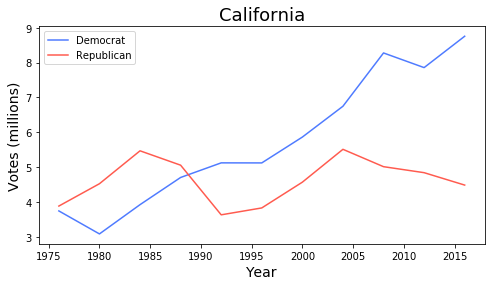

In [254]:
def getFigure(state):
    

    years = range(1976,2020,4)
    dems = []
    reps =[]
    for year in years:

        result = results[year][state]
        dems.append(result['dem']/1000000)  
        reps.append(result['rep']/1000000) 

    fig = plt.figure(figsize=(8,4))
    plt.plot(years,dems,label='Democrat',color='#4f7bff')
    plt.plot(years,reps,label='Republican',color='#ff5b4f')

    plt.title(state,size = 18)
    plt.ticklabel_format(style='plain')
    plt.xlabel('Year',size =14)
    plt.ylabel('Votes (millions)',size =14)

    plt.legend(loc =0)

    html = mpld3.fig_to_html(fig)
    
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

getFigure('California')

In [272]:
def marker_style(feature): 
    return {'fillOpacity': 0,
             'weight': 1,
             'fillColor': '#000000',
             'color': '#000000'}    
def highlight_style(feature): 
        return {'fillOpacity': 0.2,
             'weight': 1,
             'fillColor': '#000000',
             'color': '#000000'}   

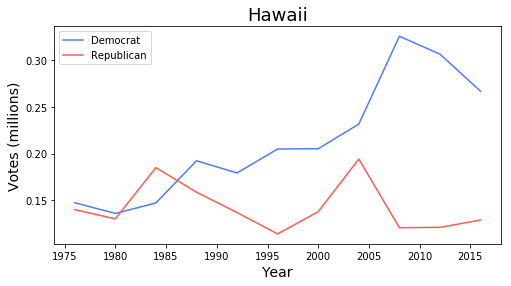

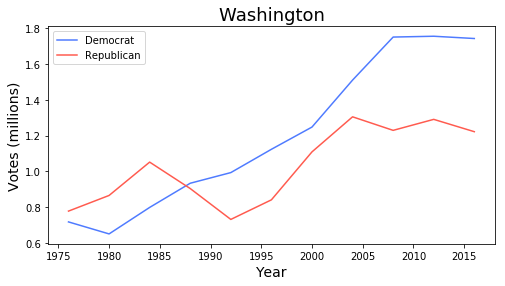

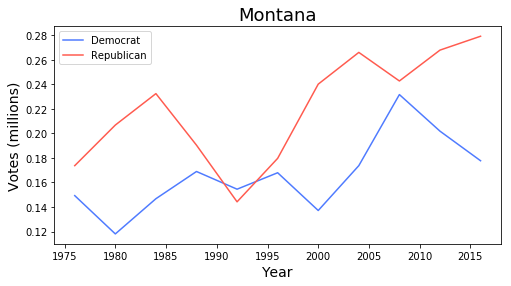

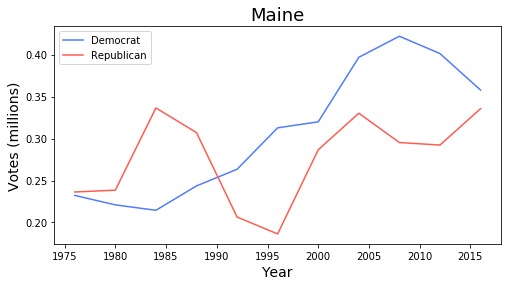

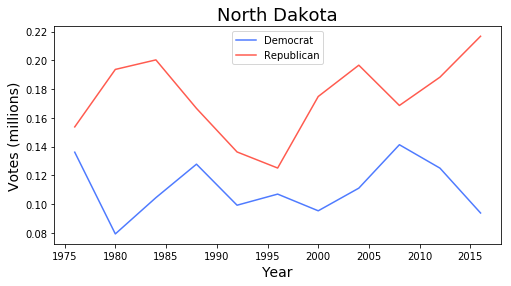

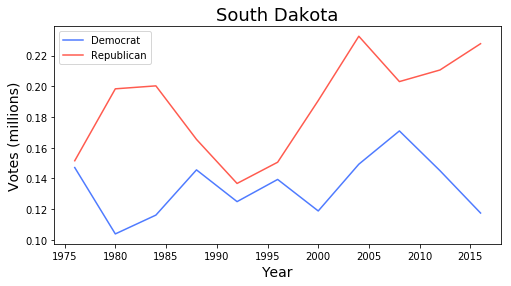

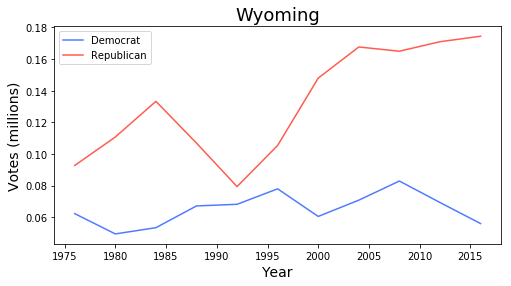

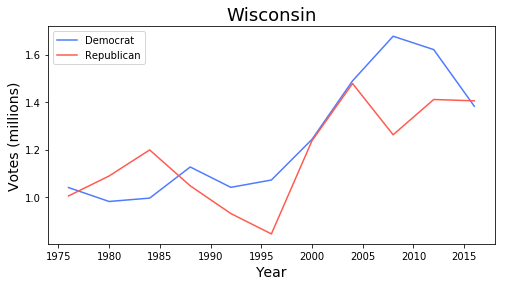

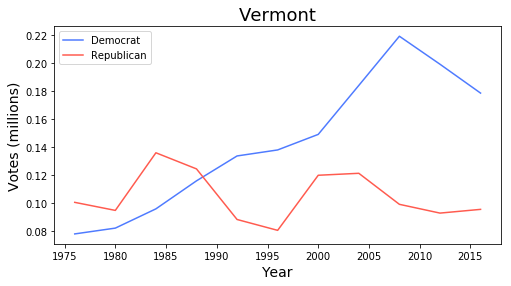

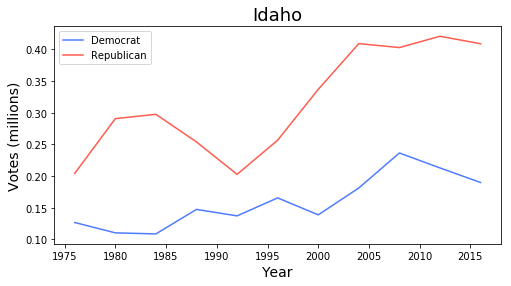

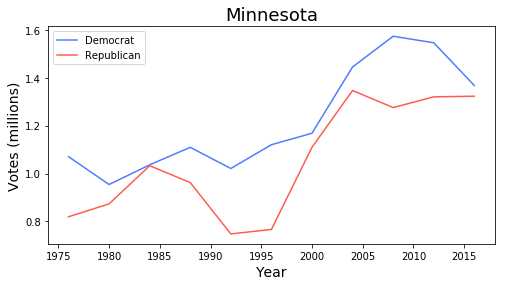

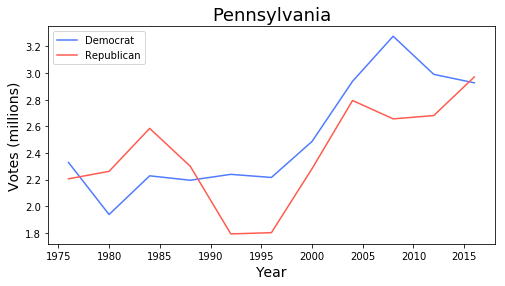

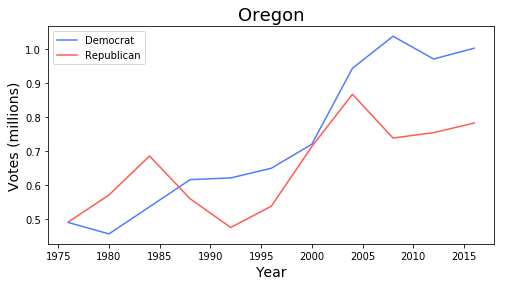

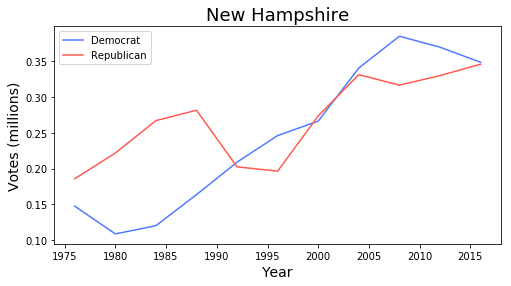

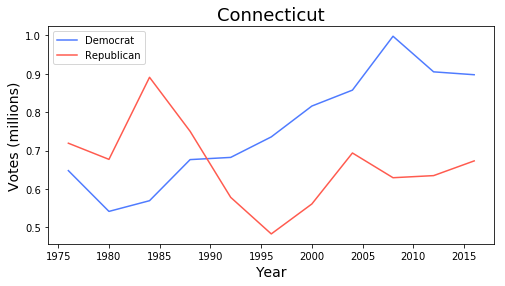

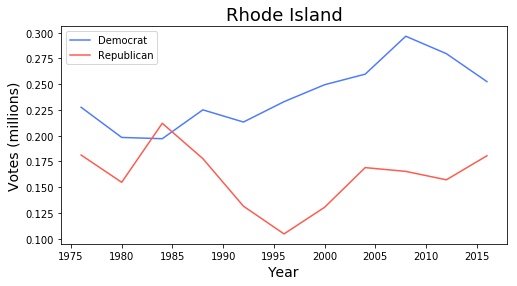

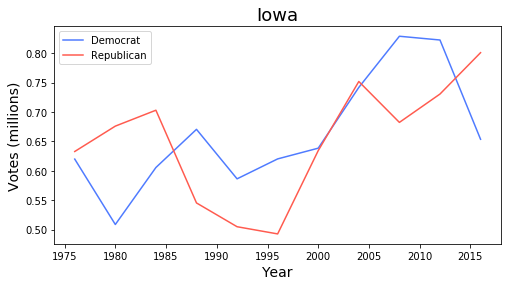

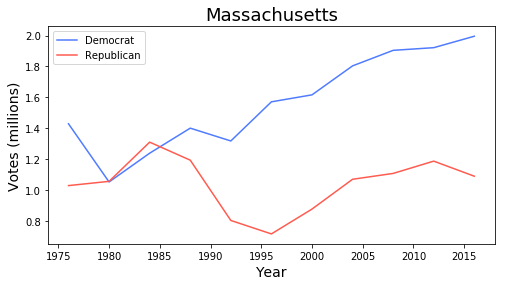

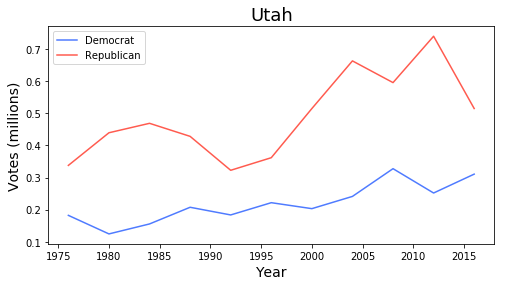

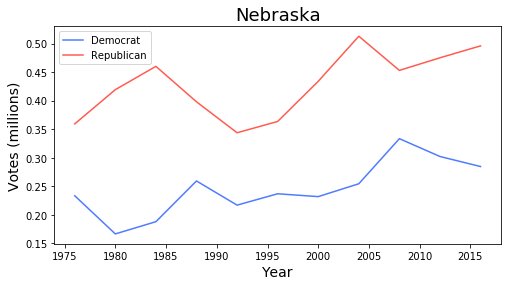

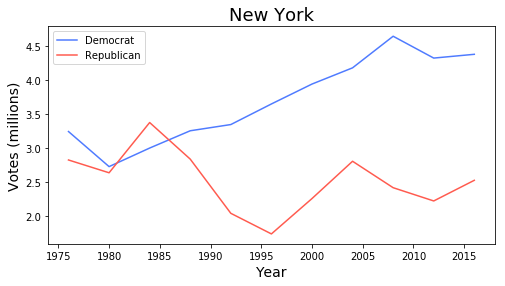

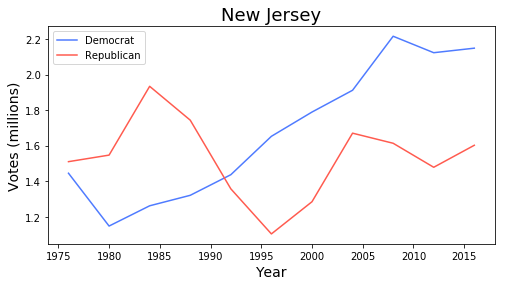

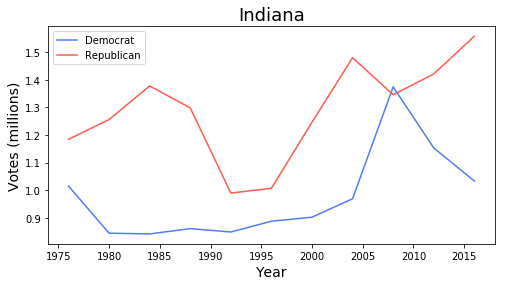

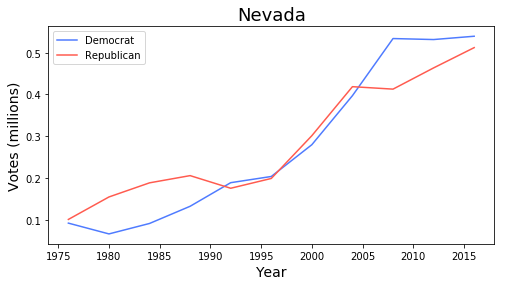

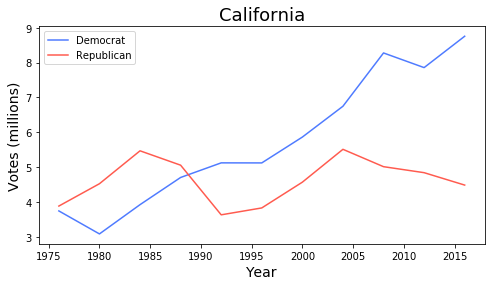

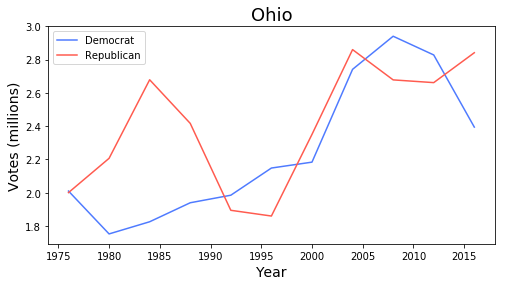

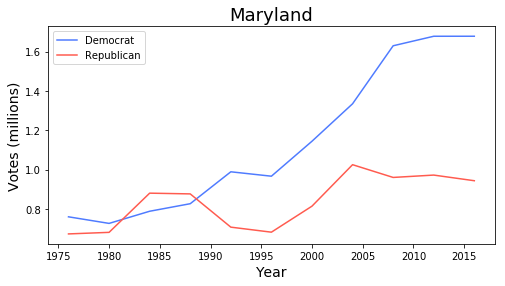

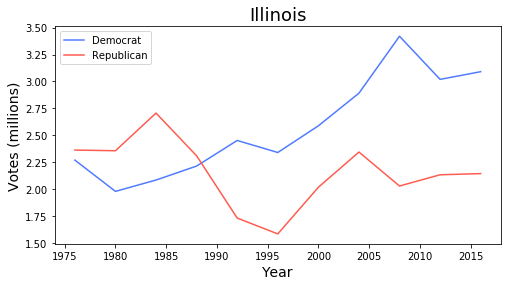

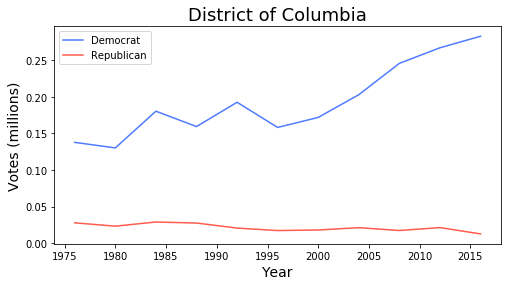

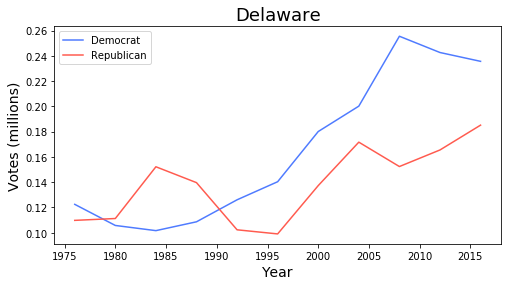

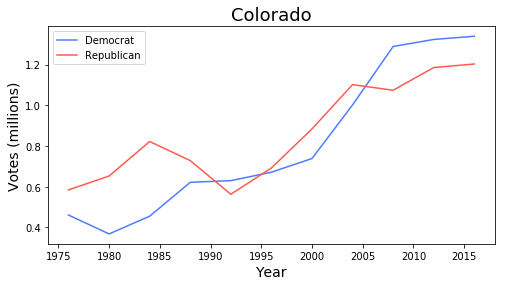

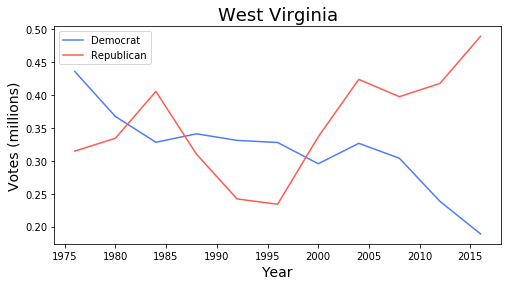

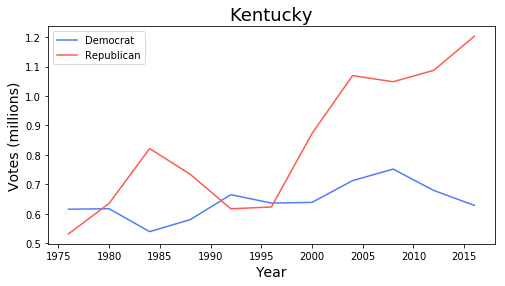

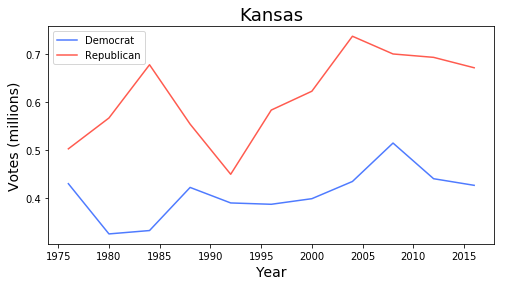

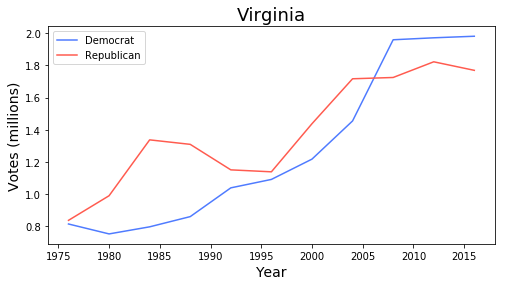

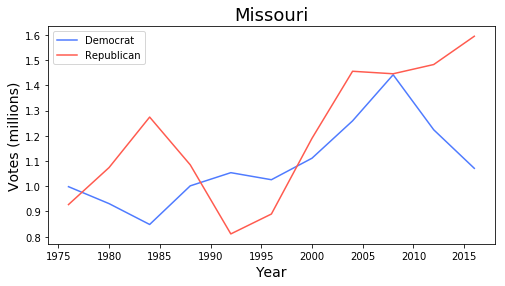

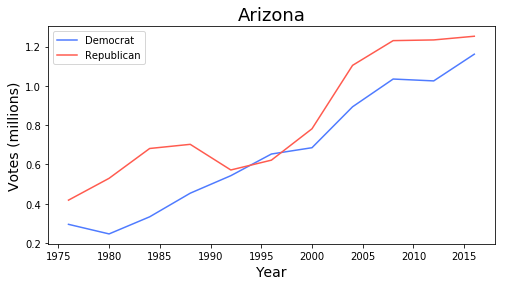

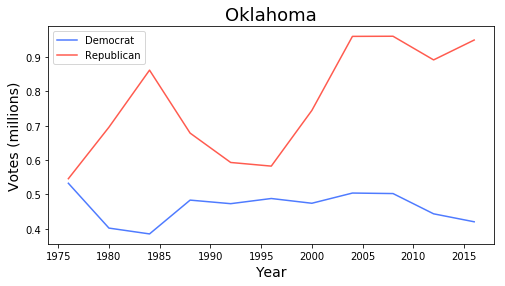

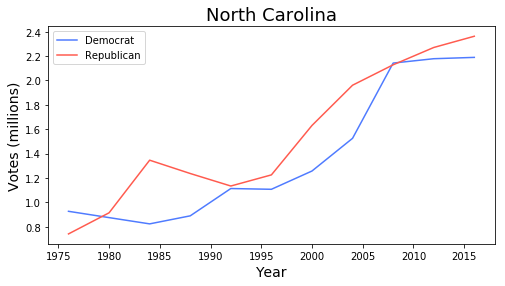

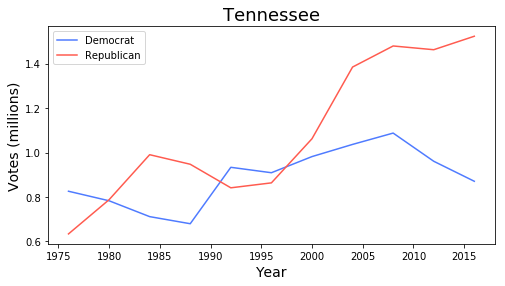

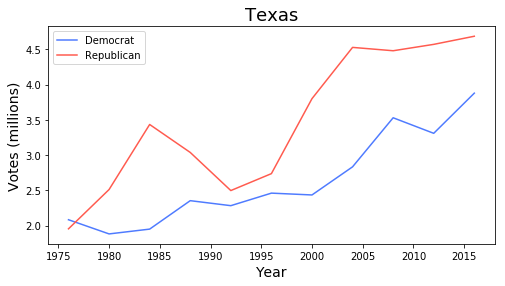

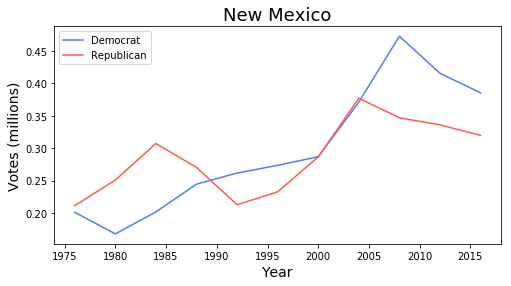

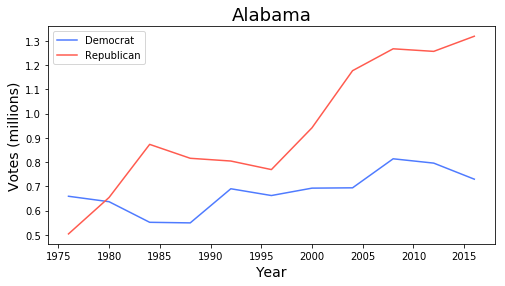

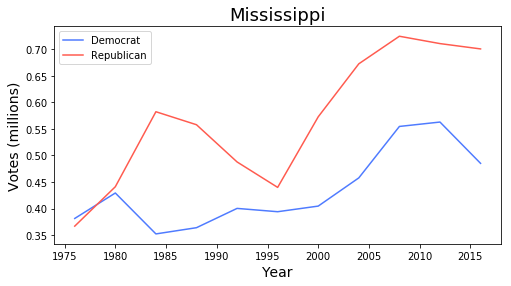

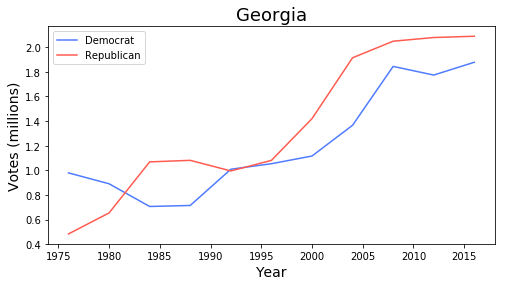

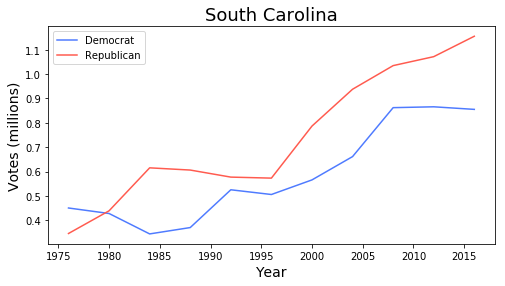

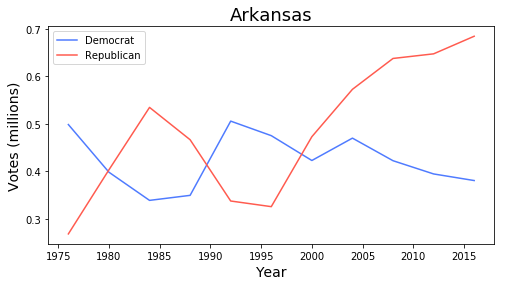

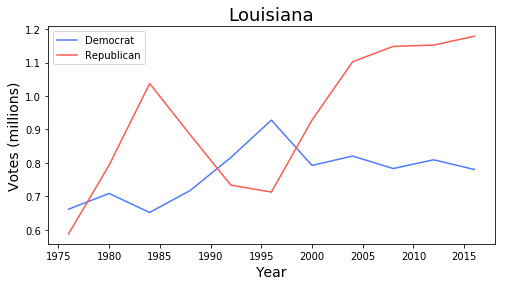

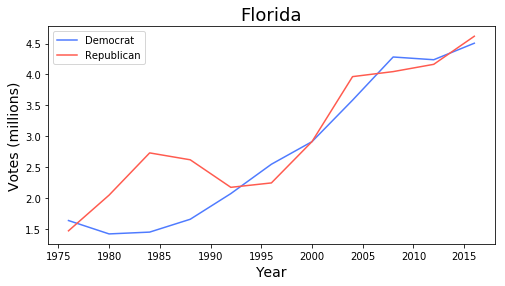

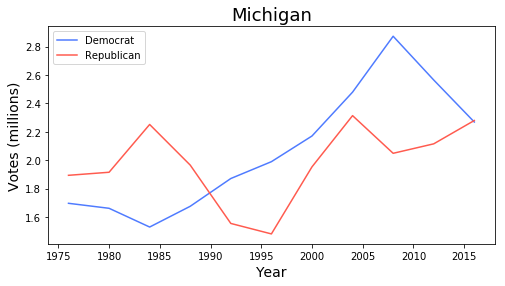

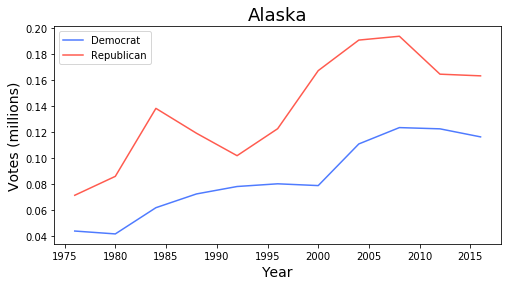

In [279]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=4,max_zoom=4) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json(),
                           style_function=style_function)
m.add_child(choropleth)

for i in range(len(us_shape)):
    
    geometry = us_shape.loc[i]['geometry']
    state_name = us_shape.loc[i]['state_name']
    popup = folium.Popup(getFigure(state_name),max_width=1000)
    
    state_marker = folium.GeoJson(data=mapping(geometry),
                                  style_function = marker_style,
                                  highlight_function = highlight_style)
    state_marker.add_child(popup)
    m.add_child(state_marker)

m.save("../figures/us_election_map2.html")